## Bayes Project 

In [1]:
#READ ME
#To run file, ensure the following packages are installed: pymc3, numpy, matplotlib,
#arviz, graphviz, scipy, seaborn, theano.

#Once correct packages are installed, restart kernel and run the entire file.

In [129]:
#!pip install dataframe_image 

In [2]:
import pymc3 as pm
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import arviz as az
import pandas as pd
import graphviz
from pymc3.distributions import draw_values
from pymc3.distributions.dist_math import bound
from pymc3.math import logsumexp
import scipy as sp
import scipy.stats as st
import seaborn as sns
from theano import shared, tensor as tt

## Cleaning the Data

In [3]:
#loads in raw data
pd.set_option('display.max_columns', None)
credit_default = pd.read_excel('default_of_credit_card_clients.xls', index_col=0)  
credit_default

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [4]:
#change column headers using first row of dataframe
new_header = credit_default.iloc[0] 
credit_default = credit_default[1:] 
credit_default.columns = new_header 

In [5]:
credit_default

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,-1,-1,-1,-1,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,4,3,2,-1,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,0,-1,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [6]:
#provides description of the features
credit_default.describe()

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,81,2,7,4,56,11,11,11,11,10,10,22723,22346,22026,21548,21010,20604,7943,7899,7518,6937,6897,6939,2
top,50000,2,2,2,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
freq,3365,18112,14030,15964,1605,14737,15730,15764,16455,16947,16286,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,23364


In [7]:
#check data type of each column
credit_default.dtypes

ID
LIMIT_BAL                     object
SEX                           object
EDUCATION                     object
MARRIAGE                      object
AGE                           object
PAY_0                         object
PAY_2                         object
PAY_3                         object
PAY_4                         object
PAY_5                         object
PAY_6                         object
BILL_AMT1                     object
BILL_AMT2                     object
BILL_AMT3                     object
BILL_AMT4                     object
BILL_AMT5                     object
BILL_AMT6                     object
PAY_AMT1                      object
PAY_AMT2                      object
PAY_AMT3                      object
PAY_AMT4                      object
PAY_AMT5                      object
PAY_AMT6                      object
default payment next month    object
dtype: object

In [8]:
#rename response column
credit_default = credit_default.rename(columns={'default payment next month': "DEFAULT"})

In [9]:
#convert datatype of each column to numeric
credit_default = credit_default.apply(pd.to_numeric)

In [10]:
#rename PAY and BILL_AMT and PAY_AMT columns to more descriptive column names
credit_default.rename(columns={'PAY_0':'PAY_DELAY_9_2005', 
                   'PAY_2':'PAY_DELAY_8_2005', 
                   'PAY_3':'PAY_DELAY_7_2005', 
                   'PAY_4':'PAY_DELAY_6_2005',
                   'PAY_5':'PAY_DELAY_5_2005',
                   'PAY_6':'PAY_DELAY_4_2005',
                   'BILL_AMT1':'BILL_AMOUNT_9_2005',
                   'BILL_AMT2':'BILL_AMOUNT_8_2005',
                   'BILL_AMT3':'BILL_AMOUNT_7_2005',
                   'BILL_AMT4':'BILL_AMOUNT_6_2005',
                   'BILL_AMT5':'BILL_AMOUNT_5_2005',
                   'BILL_AMT6':'BILL_AMOUNT_4_2005',
                   'PAY_AMT1': 'PAID_AMOUNT_9_2005',
                   'PAY_AMT2': 'PAID_AMOUNT_8_2005',
                   'PAY_AMT3': 'PAID_AMOUNT_7_2005',
                   'PAY_AMT4': 'PAID_AMOUNT_6_2005',
                   'PAY_AMT5': 'PAID_AMOUNT_5_2005',
                   'PAY_AMT6': 'PAID_AMOUNT_4_2005'}, inplace=True)

In [11]:
#check row values for PAY_DELAY columns
PAY_DELAY_list = ['PAY_DELAY_9_2005','PAY_DELAY_8_2005', 'PAY_DELAY_7_2005', 'PAY_DELAY_6_2005','PAY_DELAY_5_2005', 'PAY_DELAY_4_2005']
for column in PAY_DELAY_list:
    print(credit_default[column].unique()) #-2 should not be a valid value, need to replace with -1 (represents paid duly)

[ 2 -1  0 -2  1  3  4  8  7  5  6]
[ 2  0 -1 -2  3  5  7  4  1  6  8]
[-1  0  2 -2  3  4  6  7  1  5  8]
[-1  0 -2  2  3  4  5  7  6  1  8]
[-2  0 -1  2  3  5  4  7  8  6]
[-2  2  0 -1  3  6  4  7  8  5]


In [12]:
#Iterate over PAY_DELAY columns, and collapse their values to 0 (paid on time) and 1 (did not paid on time)
for column in PAY_DELAY_list:
    credit_default[column].replace({-2:0}, inplace=True)
    credit_default[column].replace({-1:0}, inplace=True)
    credit_default[column].replace({2:1}, inplace=True)
    credit_default[column].replace({3:1}, inplace=True)
    credit_default[column].replace({4:1}, inplace=True)
    credit_default[column].replace({5:1}, inplace=True)
    credit_default[column].replace({6:1}, inplace=True)
    credit_default[column].replace({7:1}, inplace=True)
    credit_default[column].replace({8:1}, inplace=True)

In [13]:
credit_default

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
1,20000,2,2,1,24,1,1,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,1,0,0,0,1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,1,1,1,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,0,0,0,0,0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [14]:
#check that 0 and 1 are the only values in the PAY_DELAY columns
for column in PAY_DELAY_list:
    print(credit_default[column].unique()) 

[1 0]
[1 0]
[0 1]
[0 1]
[0 1]
[0 1]


In [15]:
#extract categorical columns
categorical_vars = credit_default[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_DELAY_9_2005',
                                  'PAY_DELAY_8_2005', 'PAY_DELAY_7_2005', 'PAY_DELAY_6_2005', 
                                   'PAY_DELAY_5_2005', 'PAY_DELAY_4_2005']]

In [16]:
#convert dtypes of SEX, EDUCATION, MARRIAGE to string
categorical_vars['SEX'] = categorical_vars['SEX'].astype(str)
categorical_vars['EDUCATION'] = categorical_vars['EDUCATION'].astype(str)
categorical_vars['MARRIAGE'] = categorical_vars['MARRIAGE'].astype(str)

<ipython-input-16-c231eeef88df>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['SEX'] = categorical_vars['SEX'].astype(str)
<ipython-input-16-c231eeef88df>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  categorical_vars['EDUCATION'] = categorical_vars['EDUCATION'].astype(str)
<ipython-input-16-c231eeef88df>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [17]:
#replace label encoded values with strings
categorical_vars["SEX"].replace({"1": "male", "2": "female"}, inplace=True)
categorical_vars["EDUCATION"].replace({"1": "graduate.school", "2": "university", "3":"high.school", "4":"others"}, inplace=True)
categorical_vars["MARRIAGE"].replace({"1": "married", "2": "single", "3":"others"}, inplace=True)


/Users/nicholaslandi/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [18]:
categorical_vars

ID,SEX,EDUCATION,MARRIAGE,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005
1,female,university,married,1,1,0,0,0,0
2,female,university,single,0,1,0,0,0,1
3,female,university,single,0,0,0,0,0,0
4,female,university,married,0,0,0,0,0,0
5,male,university,married,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
29996,male,high.school,married,0,0,0,0,0,0
29997,male,high.school,single,0,0,0,0,0,0
29998,male,university,single,1,1,1,0,0,0
29999,male,high.school,married,1,0,0,0,0,0


In [19]:
#determine incorrectly inputted values (none)
categorical_vars['SEX'].value_counts()

female    18112
male      11888
Name: SEX, dtype: int64

In [20]:
#determine incorrectly inputted values (5,6,0)
categorical_vars['EDUCATION'].value_counts()

university         14030
graduate.school    10585
high.school         4917
5                    280
others               123
6                     51
0                     14
Name: EDUCATION, dtype: int64

In [21]:
#determine incorrectly inputted values (0)
categorical_vars['MARRIAGE'].value_counts()

single     15964
married    13659
others       323
0             54
Name: MARRIAGE, dtype: int64

In [22]:
#drop rows from categorical df that contain incorrectly inputted values
filter1_cat = categorical_vars.loc[(categorical_vars['EDUCATION'] != "5")]
filter2_cat = filter1_cat.loc[(filter1_cat['EDUCATION'] != "6")]
filter3_cat = filter2_cat.loc[(filter2_cat['EDUCATION'] != "0")]
filter4_cat = filter3_cat.loc[(filter3_cat['MARRIAGE'] != "0")]
categorical_vars = filter4_cat.loc[(filter4_cat['MARRIAGE'] != "others")]
categorical_vars

ID,SEX,EDUCATION,MARRIAGE,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005
1,female,university,married,1,1,0,0,0,0
2,female,university,single,0,1,0,0,0,1
3,female,university,single,0,0,0,0,0,0
4,female,university,married,0,0,0,0,0,0
5,male,university,married,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
29996,male,high.school,married,0,0,0,0,0,0
29997,male,high.school,single,0,0,0,0,0,0
29998,male,university,single,1,1,1,0,0,0
29999,male,high.school,married,1,0,0,0,0,0


In [23]:
#drop rows from credit_default df that contain incorrectly inputted values 
filter1_cd = credit_default.loc[(credit_default['EDUCATION'] != 5)]
filter2_cd = filter1_cd.loc[(filter1_cd['EDUCATION'] != 6)]
filter3_cd = filter2_cd.loc[(filter2_cd['EDUCATION'] != 0)]
filter4_cd = filter3_cd.loc[(filter3_cd['MARRIAGE'] != 0)]
credit_default = filter4_cd.loc[(filter4_cd['MARRIAGE'] != 3)]
credit_default

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
1,20000,2,2,1,24,1,1,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,1,0,0,0,1,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29996,220000,1,3,1,39,0,0,0,0,0,0,188948,192815,208365,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29997,150000,1,3,2,43,0,0,0,0,0,0,1683,1828,3502,8979,5190,0,1837,3526,8998,129,0,0,0
29998,30000,1,2,2,37,1,1,1,0,0,0,3565,3356,2758,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,0,0,0,0,0,-1645,78379,76304,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


In [24]:
#extract response column and drop from predictor df 
y = credit_default['DEFAULT']
credit_default = credit_default.drop(['DEFAULT'], axis=1)

In [25]:
#reset index of response df 
y = y.reset_index().drop(['index'], axis = 1)
y

,DEFAULT
0,1
1,1
2,0
3,0
4,0
...,...
29278,0
29279,0
29280,1
29281,1


In [26]:
#one hot encode correct categorical variables
one_hot_df = pd.get_dummies(categorical_vars, columns=["SEX", "EDUCATION", "MARRIAGE"], prefix=["SEX", "EDUCATION", "MARRIAGE"])
one_hot_df = one_hot_df.reset_index()
one_hot_df

,index,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single
0,1,1,1,0,0,0,0,1,0,0,0,0,1,1,0
1,2,0,1,0,0,0,1,1,0,0,0,0,1,0,1
2,3,0,0,0,0,0,0,1,0,0,0,0,1,0,1
3,4,0,0,0,0,0,0,1,0,0,0,0,1,1,0
4,5,0,0,0,0,0,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,29996,0,0,0,0,0,0,0,1,0,1,0,0,1,0
29279,29997,0,0,0,0,0,0,0,1,0,1,0,0,0,1
29280,29998,1,1,1,0,0,0,0,1,0,0,0,1,0,1
29281,29999,1,0,0,0,0,0,0,1,0,1,0,0,1,0


In [27]:
#drop sex, marriage and education from credit_default df 
credit_default = credit_default.drop(['SEX', 'EDUCATION', 'MARRIAGE', "PAY_DELAY_9_2005", "PAY_DELAY_8_2005", 
                                     "PAY_DELAY_7_2005", "PAY_DELAY_6_2005", "PAY_DELAY_5_2005", "PAY_DELAY_4_2005"], 
                                     axis = 1)

In [28]:
#credit_default.columns

In [29]:
#standardize numeric columns left in credit_default df
mean = credit_default.mean()
std = credit_default.std()
x_numeric = np.array((credit_default - mean)/std)
x_numeric
numeric_standardized = pd.DataFrame(x_numeric, columns=['LIMIT_BAL', 'AGE',
       'BILL_AMOUNT_9_2005', 'BILL_AMOUNT_8_2005',
       'BILL_AMOUNT_7_2005', 'BILL_AMOUNT_6_2005', 'BILL_AMOUNT_5_2005',
       'BILL_AMOUNT_4_2005', 'PAID_AMOUNT_9_2005', 'PAID_AMOUNT_8_2005',
       'PAID_AMOUNT_7_2005', 'PAID_AMOUNT_6_2005', 'PAID_AMOUNT_5_2005',
       'PAID_AMOUNT_4_2005'])
numeric_standardized

,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005
0,-1.140385,-1.240372,-0.641257,-0.646391,-0.667225,-0.671989,-0.663271,-0.653304,-0.355940,-0.234815,-0.307688,-0.314072,-0.316427,-0.294112
1,-0.371474,-1.022458,-0.658001,-0.665762,-0.638461,-0.621157,-0.606501,-0.598639,-0.355940,-0.220728,-0.248375,-0.248989,-0.316427,-0.181000
2,-0.602147,-0.150802,-0.296768,-0.492706,-0.481481,-0.449352,-0.417656,-0.392650,-0.260063,-0.198078,-0.248375,-0.248989,-0.250532,-0.011332
3,-0.909711,0.176070,-0.055316,-0.011522,0.034213,-0.232122,-0.187436,-0.157997,-0.229620,-0.174569,-0.236512,-0.242481,-0.245986,-0.237556
4,-0.909711,2.355211,-0.577272,-0.610266,-0.159988,-0.346680,-0.348677,-0.332604,-0.229620,1.395551,0.285448,0.271674,-0.271026,-0.255710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,0.397436,0.393984,1.875623,2.022350,2.330013,0.695181,-0.150006,-0.385425,0.180919,0.639935,-0.010942,-0.115765,0.013046,-0.237556
29279,-0.140801,0.829812,-0.671590,-0.664313,-0.626627,-0.532497,-0.577993,-0.653304,-0.239915,-0.106305,0.226016,-0.305677,-0.316427,-0.294112
29280,-1.063494,0.176070,-0.645990,-0.642818,-0.637364,-0.347643,-0.325082,-0.328816,-0.355940,-0.266026,0.997212,-0.040724,-0.184638,-0.118789
29281,-0.679038,0.611898,-0.716858,0.412550,0.424072,0.147872,-0.468478,0.167162,5.069491,-0.111605,-0.237817,-0.188723,3.173613,-0.192085


In [30]:
#merge encoded categorical variables and standardized numeric variables
clean_credit_df_full = pd.concat([one_hot_df,numeric_standardized],axis=1).drop(['index'], axis = 1)
clean_credit_df_full

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005
0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,-1.140385,-1.240372,-0.641257,-0.646391,-0.667225,-0.671989,-0.663271,-0.653304,-0.355940,-0.234815,-0.307688,-0.314072,-0.316427,-0.294112
1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,-0.371474,-1.022458,-0.658001,-0.665762,-0.638461,-0.621157,-0.606501,-0.598639,-0.355940,-0.220728,-0.248375,-0.248989,-0.316427,-0.181000
2,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.602147,-0.150802,-0.296768,-0.492706,-0.481481,-0.449352,-0.417656,-0.392650,-0.260063,-0.198078,-0.248375,-0.248989,-0.250532,-0.011332
3,0,0,0,0,0,0,1,0,0,0,0,1,1,0,-0.909711,0.176070,-0.055316,-0.011522,0.034213,-0.232122,-0.187436,-0.157997,-0.229620,-0.174569,-0.236512,-0.242481,-0.245986,-0.237556
4,0,0,0,0,0,0,0,1,0,0,0,1,1,0,-0.909711,2.355211,-0.577272,-0.610266,-0.159988,-0.346680,-0.348677,-0.332604,-0.229620,1.395551,0.285448,0.271674,-0.271026,-0.255710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.397436,0.393984,1.875623,2.022350,2.330013,0.695181,-0.150006,-0.385425,0.180919,0.639935,-0.010942,-0.115765,0.013046,-0.237556
29279,0,0,0,0,0,0,0,1,0,1,0,0,0,1,-0.140801,0.829812,-0.671590,-0.664313,-0.626627,-0.532497,-0.577993,-0.653304,-0.239915,-0.106305,0.226016,-0.305677,-0.316427,-0.294112
29280,1,1,1,0,0,0,0,1,0,0,0,1,0,1,-1.063494,0.176070,-0.645990,-0.642818,-0.637364,-0.347643,-0.325082,-0.328816,-0.355940,-0.266026,0.997212,-0.040724,-0.184638,-0.118789
29281,1,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.679038,0.611898,-0.716858,0.412550,0.424072,0.147872,-0.468478,0.167162,5.069491,-0.111605,-0.237817,-0.188723,3.173613,-0.192085


## Feature Selection

In [31]:
#determine number of rows
n = clean_credit_df_full.shape[0]
n 

29283

In [32]:
#determine number of predictors in full df
k_full = len(clean_credit_df_full.columns)
k_full

28

In [33]:
clean_credit_df_full.columns

Index(['PAY_DELAY_9_2005', 'PAY_DELAY_8_2005', 'PAY_DELAY_7_2005',
       'PAY_DELAY_6_2005', 'PAY_DELAY_5_2005', 'PAY_DELAY_4_2005',
       'SEX_female', 'SEX_male', 'EDUCATION_graduate.school',
       'EDUCATION_high.school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married', 'MARRIAGE_single', 'LIMIT_BAL', 'AGE',
       'BILL_AMOUNT_9_2005', 'BILL_AMOUNT_8_2005', 'BILL_AMOUNT_7_2005',
       'BILL_AMOUNT_6_2005', 'BILL_AMOUNT_5_2005', 'BILL_AMOUNT_4_2005',
       'PAID_AMOUNT_9_2005', 'PAID_AMOUNT_8_2005', 'PAID_AMOUNT_7_2005',
       'PAID_AMOUNT_6_2005', 'PAID_AMOUNT_5_2005', 'PAID_AMOUNT_4_2005'],
      dtype='object')

In [34]:
#subset reduced df (remove all PAY_DELAY, BILL_AMOUNT AND PAID_AMOUNT columns except for ones corresponding 
#most recent month)
clean_credit_df_reduced = clean_credit_df_full[['SEX_female', 'SEX_male', 'EDUCATION_graduate.school',
       'EDUCATION_high.school', 'EDUCATION_others', 'EDUCATION_university',
       'MARRIAGE_married','MARRIAGE_single', 'LIMIT_BAL',
       'AGE', 'PAY_DELAY_9_2005', 'BILL_AMOUNT_9_2005','PAID_AMOUNT_9_2005']]
clean_credit_df_reduced

,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,PAY_DELAY_9_2005,BILL_AMOUNT_9_2005,PAID_AMOUNT_9_2005
0,1,0,0,0,0,1,1,0,-1.140385,-1.240372,1,-0.641257,-0.355940
1,1,0,0,0,0,1,0,1,-0.371474,-1.022458,0,-0.658001,-0.355940
2,1,0,0,0,0,1,0,1,-0.602147,-0.150802,0,-0.296768,-0.260063
3,1,0,0,0,0,1,1,0,-0.909711,0.176070,0,-0.055316,-0.229620
4,0,1,0,0,0,1,1,0,-0.909711,2.355211,0,-0.577272,-0.229620
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29278,0,1,0,1,0,0,1,0,0.397436,0.393984,0,1.875623,0.180919
29279,0,1,0,1,0,0,0,1,-0.140801,0.829812,0,-0.671590,-0.239915
29280,0,1,0,0,0,1,0,1,-1.063494,0.176070,1,-0.645990,-0.355940
29281,0,1,0,1,0,0,1,0,-0.679038,0.611898,1,-0.716858,5.069491


In [35]:
#determine number of predictors in reduced df 
k2 = len(clean_credit_df_reduced.columns)
k2

13

In [36]:
#determine number of defaults/non-defaults 
y['DEFAULT'].value_counts() #22762 vs 6521, stratify so defaults are 1/5 of sample data

0    22762
1     6521
Name: DEFAULT, dtype: int64

In [37]:
#add default column back to clean_credit_df_full and subset default and non-default rows into two seperte dataframes
clean_credit_df_full['DEFAULT'] = y
response_defaulted = clean_credit_df_full.loc[(clean_credit_df_full['DEFAULT'] == 1)]
response_no_default = clean_credit_df_full.loc[(clean_credit_df_full['DEFAULT'] == 0)]
response_defaulted

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
0,1,1,0,0,0,0,1,0,0,0,0,1,1,0,-1.140385,-1.240372,-0.641257,-0.646391,-0.667225,-0.671989,-0.663271,-0.653304,-0.355940,-0.234815,-0.307688,-0.314072,-0.316427,-0.294112,1
1,0,1,0,0,0,1,1,0,0,0,0,1,0,1,-0.371474,-1.022458,-0.658001,-0.665762,-0.638461,-0.621157,-0.606501,-0.598639,-0.355940,-0.220728,-0.248375,-0.248989,-0.316427,-0.181000,1
13,1,1,1,0,0,1,0,1,0,0,0,1,0,1,-0.755929,-0.586630,0.200569,0.257669,0.271047,0.365490,-0.069492,-0.034837,-0.153828,-0.266026,-0.129747,-0.118824,-0.217585,-0.294112,1
15,0,0,1,1,1,1,0,1,1,0,0,0,0,1,-1.140385,-1.240372,-0.485335,-0.436676,-0.425643,-0.387102,-0.369068,-0.333057,-0.153828,-0.266026,-0.218718,-0.314072,-0.207701,-0.294112,1
20,0,0,0,0,0,0,1,0,0,0,0,1,1,0,-0.371474,0.393984,-0.690184,-0.685582,-0.672608,-0.671989,-0.652887,-0.648007,-0.335981,-0.251711,-0.307688,-0.272940,-0.295604,-0.294112,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29274,1,1,1,1,1,1,0,1,0,0,0,1,1,0,0.320545,-0.150802,-0.660477,-0.654860,-0.641088,-0.633151,-0.622193,-0.611396,-0.355940,-0.266026,-0.307688,-0.314072,-0.316427,-0.294112,1
29277,1,1,1,1,1,1,0,1,0,0,0,1,0,1,-0.679038,-0.150802,0.292451,0.403111,0.468524,0.532293,0.694072,0.707177,0.086179,-0.107482,-0.307688,0.141508,-0.316427,-0.067888,1
29280,1,1,1,0,0,0,0,1,0,0,0,1,0,1,-1.063494,0.176070,-0.645990,-0.642818,-0.637364,-0.347643,-0.325082,-0.328816,-0.355940,-0.266026,0.997212,-0.040724,-0.184638,-0.118789,1
29281,1,0,0,0,0,0,0,1,0,1,0,0,1,0,-0.679038,0.611898,-0.716858,0.412550,0.424072,0.147872,-0.468478,0.167162,5.069491,-0.111605,-0.237817,-0.188723,3.173613,-0.192085,1


In [38]:
response_no_default

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
2,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.602147,-0.150802,-0.296768,-0.492706,-0.481481,-0.449352,-0.417656,-0.392650,-0.260063,-0.198078,-0.248375,-0.248989,-0.250532,-0.011332,0
3,0,0,0,0,0,0,1,0,0,0,0,1,1,0,-0.909711,0.176070,-0.055316,-0.011522,0.034213,-0.232122,-0.187436,-0.157997,-0.229620,-0.174569,-0.236512,-0.242481,-0.245986,-0.237556,0
4,0,0,0,0,0,0,0,1,0,0,0,1,1,0,-0.909711,2.355211,-0.577272,-0.610266,-0.159988,-0.346680,-0.348677,-0.332604,-0.229620,1.395551,0.285448,0.271674,-0.271026,-0.255710,0
5,0,0,0,0,0,0,0,1,1,0,0,0,0,1,-0.909711,0.176070,0.181498,0.112776,0.154246,-0.370697,-0.340905,-0.317634,-0.198040,-0.183810,-0.268719,-0.248989,-0.250532,-0.248867,0
6,0,0,0,0,0,0,0,1,1,0,0,0,0,1,2.550385,-0.695587,4.310645,5.106005,5.745297,7.758297,7.273113,7.291589,3.117852,1.545895,1.946230,1.003140,0.589623,0.484662,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29273,0,0,0,0,0,0,0,1,0,0,0,1,1,0,-0.217692,0.611898,1.187040,1.239184,1.330506,1.475955,0.152955,0.119839,0.023019,0.051061,-0.056910,-0.216123,-0.184638,-0.181000,0
29275,0,0,0,0,0,0,0,1,0,1,0,0,1,0,-1.217276,0.829812,-0.574756,-0.543728,-0.677169,-0.671989,-0.663271,-0.653304,-0.229620,-0.266026,-0.307688,-0.314072,-0.316427,-0.294112,0
29276,0,0,0,0,0,0,0,1,1,0,0,0,0,1,-0.525256,0.285027,-0.653104,-0.669954,0.809299,0.425208,0.478263,0.268748,-0.229620,4.797567,-0.070434,-0.118824,-0.184638,-0.181000,0
29278,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0.397436,0.393984,1.875623,2.022350,2.330013,0.695181,-0.150006,-0.385425,0.180919,0.639935,-0.010942,-0.115765,0.013046,-0.237556,0


In [39]:
#randomly select a representative sample from the default and non-default dataframes
SEED = 200
np.random.seed(SEED)
sample_defaulted = response_defaulted.sample(100)
sample_no_default = response_no_default.sample(400)
sample_total_defaulted = response_defaulted.sample(500)

In [40]:
total_default = pd.DataFrame(sample_total_defaulted)
total_default

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
6507,0,0,0,0,0,0,0,1,1,0,0,0,1,0,1.627693,0.393984,-0.608149,-0.690028,-0.677169,0.048073,-0.663271,-0.653304,-0.355940,-0.266026,2.441498,-0.314072,-0.316427,1.063229,1
5536,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0.628109,2.137297,3.344863,2.653534,1.893957,2.139794,1.892064,1.443172,0.149339,0.069180,0.267654,0.017850,-0.019901,-0.067210,1
7913,1,0,0,1,1,1,1,0,0,0,0,1,1,0,0.705000,0.393984,1.155510,1.268345,1.431777,1.559457,1.875879,1.811178,-0.014877,0.164306,-0.307688,0.516776,-0.316427,-0.294112,1
23964,0,0,1,1,0,0,0,1,0,1,0,0,0,1,-1.140385,1.374598,-0.510268,-0.458846,-0.425296,-0.409768,-0.382969,-0.363918,-0.158123,-0.194591,-0.307688,-0.264804,-0.275045,-0.254523,1
21299,1,1,1,1,1,1,1,0,1,0,0,0,0,1,-0.909711,-1.131415,-0.137350,-0.072897,-0.058154,0.005071,0.068925,0.110971,-0.109616,-0.266026,-0.206855,-0.183906,-0.191227,-0.192311,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,1,1,0,0,0,0,1,0,0,0,0,1,1,0,-0.909711,-0.913501,-0.015978,-0.069521,-0.035755,-0.368709,-0.338342,-0.312589,-0.355940,-0.208044,-0.268423,-0.259598,-0.250532,-0.230769,1
23110,0,0,0,0,0,0,1,0,0,0,0,1,1,0,-0.448365,0.285027,1.963888,1.791717,0.234114,-0.052845,-0.510575,-0.674895,-0.040141,0.186955,-0.008273,-0.183906,2.316588,2.646793,1
19451,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1.858366,0.611898,4.046681,4.296898,4.571361,5.072598,5.396260,5.538377,0.465138,0.395325,0.611673,0.597088,0.578421,0.497670,1
21506,1,1,1,1,1,0,1,0,0,0,0,1,0,1,-0.525256,-0.804544,0.291186,0.304668,0.368190,0.482627,0.560797,0.621684,-0.355940,-0.109204,-0.088228,-0.183906,-0.134558,-0.137113,1


In [41]:
#combine samples into stratified df 
frames = [sample_defaulted, sample_no_default]
strat_sample = pd.concat(frames)
strat_sample

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005,DEFAULT
1085,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.140801,0.176070,0.399990,0.470704,0.539054,0.008955,-0.105214,-0.072655,-0.144481,-0.107935,-0.224531,-0.233825,-0.234718,-0.221494,1
20997,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0.628109,-0.695587,-0.689177,-0.690028,0.032034,-0.164000,-0.121875,-0.080835,-0.355940,1.959919,-0.213024,0.011342,-0.184638,-0.192311,1
22975,1,1,1,1,0,0,1,0,0,0,0,1,1,0,-1.140385,-0.041844,-0.472290,-0.468046,-0.411456,-0.395321,-0.367359,-0.375116,-0.355940,-0.121072,-0.307688,-0.264284,-0.270301,-0.250337,1
5943,0,0,1,1,1,1,1,0,1,0,0,0,1,0,-0.217692,0.176070,0.997289,1.186319,1.281162,1.466836,1.561055,1.667667,0.338818,0.005763,0.030399,-0.314072,0.045993,-0.011332,1
20474,0,0,0,0,0,0,0,1,0,1,0,0,0,1,-1.217276,0.176070,-0.627151,-0.606145,-0.576388,-0.547815,-0.529340,-0.513799,-0.286274,-0.215156,-0.240486,-0.295133,-0.296527,-0.237556,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0.166763,-0.804544,-0.694482,-0.690028,-0.677169,-0.671989,-0.663271,-0.653304,-0.355940,-0.266026,-0.307688,-0.314072,-0.316427,-0.247283,0
7717,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0.474327,0.067113,-0.661782,-0.680448,-0.618747,-0.671989,-0.579603,-0.528383,-0.312549,-0.082433,-0.307688,0.017330,0.175410,-0.153570,0
28656,1,1,1,1,0,0,0,1,1,0,0,0,0,1,-0.755929,-0.804544,0.293104,0.306764,0.361176,0.405183,-0.171169,-0.160796,-0.355940,-0.139191,-0.307688,-0.235973,-0.237353,-0.226245,0
22132,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1.473911,0.829812,-0.634156,-0.678788,-0.661712,-0.429887,-0.610773,-0.581875,-0.305096,-0.217511,0.617842,-0.106132,-0.035123,-0.094752,0


In [42]:
#extract index of randomly sampled rows
row_list = []
for row in strat_sample.index:
    row_list.append(row)

In [43]:
row_list2 = []
for row in total_default.index:
    row_list2.append(row)

In [44]:
#extract same rows from reduced df
reduced_sample = clean_credit_df_reduced.loc[row_list]
reduced_sample 

,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,PAY_DELAY_9_2005,BILL_AMOUNT_9_2005,PAID_AMOUNT_9_2005
1085,1,0,0,0,0,1,0,1,-0.140801,0.176070,0,0.399990,-0.144481
20997,1,0,0,0,0,1,1,0,0.628109,-0.695587,0,-0.689177,-0.355940
22975,1,0,0,0,0,1,1,0,-1.140385,-0.041844,1,-0.472290,-0.355940
5943,1,0,1,0,0,0,1,0,-0.217692,0.176070,0,0.997289,0.338818
20474,0,1,0,1,0,0,0,1,-1.217276,0.176070,0,-0.627151,-0.286274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2799,1,0,0,0,0,1,0,1,0.166763,-0.804544,1,-0.694482,-0.355940
7717,1,0,0,0,0,1,0,1,0.474327,0.067113,1,-0.661782,-0.312549
28656,0,1,1,0,0,0,0,1,-0.755929,-0.804544,1,0.293104,-0.355940
22132,1,0,0,1,0,0,1,0,1.473911,0.829812,0,-0.634156,-0.305096


In [45]:
reduced_total_default = clean_credit_df_reduced.loc[row_list2]
reduced_total_default

,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,PAY_DELAY_9_2005,BILL_AMOUNT_9_2005,PAID_AMOUNT_9_2005
6507,0,1,1,0,0,0,1,0,1.627693,0.393984,0,-0.608149,-0.355940
5536,1,0,0,1,0,0,1,0,0.628109,2.137297,0,3.344863,0.149339
7913,1,0,0,0,0,1,1,0,0.705000,0.393984,1,1.155510,-0.014877
23964,0,1,0,1,0,0,0,1,-1.140385,1.374598,0,-0.510268,-0.158123
21299,1,0,1,0,0,0,0,1,-0.909711,-1.131415,1,-0.137350,-0.109616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8694,1,0,0,0,0,1,1,0,-0.909711,-0.913501,1,-0.015978,-0.355940
23110,1,0,0,0,0,1,1,0,-0.448365,0.285027,0,1.963888,-0.040141
19451,1,0,0,0,0,1,1,0,1.858366,0.611898,1,4.046681,0.465138
21506,1,0,0,0,0,1,0,1,-0.525256,-0.804544,1,0.291186,-0.355940


In [46]:
#extract same rows from response df
y_sample = y.loc[row_list]
y_sample

,DEFAULT
1085,1
20997,1
22975,1
5943,1
20474,1
...,...
2799,0
7717,0
28656,0
22132,0


In [47]:
y_sample_total_default = y.loc[row_list2]
y_sample_total_default

,DEFAULT
6507,1
5536,1
7913,1
23964,1
21299,1
...,...
8694,1
23110,1
19451,1
21506,1


In [48]:
#reset index of samples for full df 
full_sample = strat_sample.reset_index()
full_sample = full_sample.drop(['index', 'DEFAULT'], axis = 1)
full_sample 

,PAY_DELAY_9_2005,PAY_DELAY_8_2005,PAY_DELAY_7_2005,PAY_DELAY_6_2005,PAY_DELAY_5_2005,PAY_DELAY_4_2005,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,BILL_AMOUNT_9_2005,BILL_AMOUNT_8_2005,BILL_AMOUNT_7_2005,BILL_AMOUNT_6_2005,BILL_AMOUNT_5_2005,BILL_AMOUNT_4_2005,PAID_AMOUNT_9_2005,PAID_AMOUNT_8_2005,PAID_AMOUNT_7_2005,PAID_AMOUNT_6_2005,PAID_AMOUNT_5_2005,PAID_AMOUNT_4_2005
0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,-0.140801,0.176070,0.399990,0.470704,0.539054,0.008955,-0.105214,-0.072655,-0.144481,-0.107935,-0.224531,-0.233825,-0.234718,-0.221494
1,0,0,0,0,0,0,1,0,0,0,0,1,1,0,0.628109,-0.695587,-0.689177,-0.690028,0.032034,-0.164000,-0.121875,-0.080835,-0.355940,1.959919,-0.213024,0.011342,-0.184638,-0.192311
2,1,1,1,1,0,0,1,0,0,0,0,1,1,0,-1.140385,-0.041844,-0.472290,-0.468046,-0.411456,-0.395321,-0.367359,-0.375116,-0.355940,-0.121072,-0.307688,-0.264284,-0.270301,-0.250337
3,0,0,1,1,1,1,1,0,1,0,0,0,1,0,-0.217692,0.176070,0.997289,1.186319,1.281162,1.466836,1.561055,1.667667,0.338818,0.005763,0.030399,-0.314072,0.045993,-0.011332
4,0,0,0,0,0,0,0,1,0,1,0,0,0,1,-1.217276,0.176070,-0.627151,-0.606145,-0.576388,-0.547815,-0.529340,-0.513799,-0.286274,-0.215156,-0.240486,-0.295133,-0.296527,-0.237556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0.166763,-0.804544,-0.694482,-0.690028,-0.677169,-0.671989,-0.663271,-0.653304,-0.355940,-0.266026,-0.307688,-0.314072,-0.316427,-0.247283
496,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0.474327,0.067113,-0.661782,-0.680448,-0.618747,-0.671989,-0.579603,-0.528383,-0.312549,-0.082433,-0.307688,0.017330,0.175410,-0.153570
497,1,1,1,1,0,0,0,1,1,0,0,0,0,1,-0.755929,-0.804544,0.293104,0.306764,0.361176,0.405183,-0.171169,-0.160796,-0.355940,-0.139191,-0.307688,-0.235973,-0.237353,-0.226245
498,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1.473911,0.829812,-0.634156,-0.678788,-0.661712,-0.429887,-0.610773,-0.581875,-0.305096,-0.217511,0.617842,-0.106132,-0.035123,-0.094752


In [49]:
#reset index of samples for reduced df 
reduced_sample = reduced_sample.reset_index()
reduced_sample = reduced_sample.drop(['index'], axis = 1)
reduced_sample

,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,PAY_DELAY_9_2005,BILL_AMOUNT_9_2005,PAID_AMOUNT_9_2005
0,1,0,0,0,0,1,0,1,-0.140801,0.176070,0,0.399990,-0.144481
1,1,0,0,0,0,1,1,0,0.628109,-0.695587,0,-0.689177,-0.355940
2,1,0,0,0,0,1,1,0,-1.140385,-0.041844,1,-0.472290,-0.355940
3,1,0,1,0,0,0,1,0,-0.217692,0.176070,0,0.997289,0.338818
4,0,1,0,1,0,0,0,1,-1.217276,0.176070,0,-0.627151,-0.286274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,1,0,1,0.166763,-0.804544,1,-0.694482,-0.355940
496,1,0,0,0,0,1,0,1,0.474327,0.067113,1,-0.661782,-0.312549
497,0,1,1,0,0,0,0,1,-0.755929,-0.804544,1,0.293104,-0.355940
498,1,0,0,1,0,0,1,0,1.473911,0.829812,0,-0.634156,-0.305096


In [132]:
import dataframe_image as dfi
dfi.export(reduced_sample, 'reduced_sample.png', max_rows=10)

In [50]:
#reset index of samples for response df 
y_sample = y_sample.reset_index()
y_sample = y_sample.drop(['index'], axis = 1)
y_sample

,DEFAULT
0,1
1,1
2,1
3,1
4,1
...,...
495,0
496,0
497,0
498,0


In [51]:
reduced_total_default = reduced_total_default.reset_index()
reduced_total_default = reduced_total_default.drop(['index'], axis = 1)
reduced_total_default

,SEX_female,SEX_male,EDUCATION_graduate.school,EDUCATION_high.school,EDUCATION_others,EDUCATION_university,MARRIAGE_married,MARRIAGE_single,LIMIT_BAL,AGE,PAY_DELAY_9_2005,BILL_AMOUNT_9_2005,PAID_AMOUNT_9_2005
0,0,1,1,0,0,0,1,0,1.627693,0.393984,0,-0.608149,-0.355940
1,1,0,0,1,0,0,1,0,0.628109,2.137297,0,3.344863,0.149339
2,1,0,0,0,0,1,1,0,0.705000,0.393984,1,1.155510,-0.014877
3,0,1,0,1,0,0,0,1,-1.140385,1.374598,0,-0.510268,-0.158123
4,1,0,1,0,0,0,0,1,-0.909711,-1.131415,1,-0.137350,-0.109616
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,1,0,0,0,0,1,1,0,-0.909711,-0.913501,1,-0.015978,-0.355940
496,1,0,0,0,0,1,1,0,-0.448365,0.285027,0,1.963888,-0.040141
497,1,0,0,0,0,1,1,0,1.858366,0.611898,1,4.046681,0.465138
498,1,0,0,0,0,1,0,1,-0.525256,-0.804544,1,0.291186,-0.355940


In [52]:
y_sample_total_default = y_sample_total_default.reset_index()
y_sample_total_default = y_sample_total_default.drop(['index'], axis = 1)
y_sample_total_default

,DEFAULT
0,1
1,1
2,1
3,1
4,1
...,...
495,1
496,1
497,1
498,1


## MCMC SAMPLING

In [53]:
#Full model 
with pm.Model() as default_model_full:
    beta0 = pm.Normal('beta0', mu=0, sd=1)

    #mu vector of zeros length k
    beta = pm.MvNormal('beta', mu=np.zeros(k_full), cov=np.eye(k_full), shape=k_full)

    mu = beta0 + pm.math.dot(full_sample, beta)
    theta = pm.Deterministic('theta', pm.invlogit(mu))

    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_sample) 

    trace_model_full = pm.sample(1000, cores=4, tune=1000)

<ipython-input-53-be8693ec1165>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_model_full = pm.sample(1000, cores=4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3369 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [54]:
#Reduced model
with pm.Model() as default_model_reduced:
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    
    #mu vector of zeros length k
    beta = pm.MvNormal('beta', mu=np.zeros(k2), cov=np.eye(k2), shape=k2)
    
    mu = beta0 + pm.math.dot(reduced_sample, beta)
    theta = pm.Deterministic('theta', pm.invlogit(mu))
    
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_sample) 
    
    trace_model_reduced = pm.sample(1000, cores=4, tune=1000)

<ipython-input-54-28c0f0eb0700>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_model_reduced = pm.sample(1000, cores=4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1628 seconds.


In [55]:
#Reduced model (default only)
with pm.Model() as default_only_model_reduced:
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    
    #mu vector of zeros length k
    beta = pm.MvNormal('beta', mu=np.zeros(k2), cov=np.eye(k2), shape=k2)
    
    mu = beta0 + pm.math.dot(reduced_total_default, beta)
    theta = pm.Deterministic('theta', pm.invlogit(mu))
    
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_sample_total_default) 
    
    trace_model_reduced_default_only = pm.sample(1000, cores=4, tune=1000)

<ipython-input-55-5d539262700b>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_model_reduced_default_only = pm.sample(1000, cores=4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [56]:
#Sample posterior predictive for HMC full
y_HMC_model_pred_full = pm.sample_posterior_predictive_w(traces=[trace_model_full], 
                                                     samples=1000,
                                                     models=[default_model_full])

In [57]:
#Sample posterior predictive for HMC reduced
y_HMC_model_pred = pm.sample_posterior_predictive_w(traces=[trace_model_reduced], 
                                                     samples=1000,
                                                     models=[default_model_reduced])

In [58]:
#Sample posterior predictive for HMC reduced (default only)
y_HMC_model_reduced_default_only = pm.sample_posterior_predictive_w(traces=[trace_model_reduced_default_only], 
                                                     samples=1000,
                                                     models=[default_only_model_reduced])

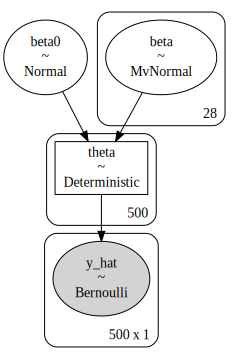

In [59]:
#graphical representation for full model
pm.model_to_graphviz(default_model_full)

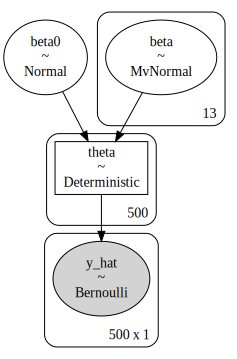

In [60]:
#graphical representation for reduced model
pm.model_to_graphviz(default_model_reduced)

In [61]:
#summary table of full model
with default_model_full:
    main_data = az.from_pymc3(trace_model_full)
az.summary(main_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.610,0.759,-2.074,0.785,0.016,0.012,2183.0,2439.0,1.0
beta[0],0.000,0.016,-0.030,0.030,0.000,0.000,3570.0,2738.0,1.0
beta[1],-0.001,0.023,-0.044,0.040,0.000,0.000,3252.0,2613.0,1.0
beta[2],0.000,0.023,-0.041,0.044,0.000,0.000,4069.0,2753.0,1.0
beta[3],-0.000,0.026,-0.050,0.049,0.000,0.000,3924.0,2610.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[495],0.200,0.003,0.194,0.205,0.000,0.000,3899.0,3523.0,1.0
theta[496],0.200,0.003,0.194,0.205,0.000,0.000,3849.0,3246.0,1.0
theta[497],0.200,0.005,0.191,0.209,0.000,0.000,5531.0,3322.0,1.0
theta[498],0.200,0.003,0.195,0.206,0.000,0.000,3183.0,3669.0,1.0


In [62]:
#summary table of reduced model
with default_model_reduced:
    reduced_data = az.from_pymc3(trace_model_reduced)
az.summary(reduced_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-0.614,0.730,-1.985,0.760,0.014,0.010,2628.0,2594.0,1.0
beta[0],-0.314,0.626,-1.455,0.861,0.012,0.009,2727.0,2878.0,1.0
beta[1],-0.314,0.626,-1.476,0.838,0.012,0.009,2729.0,2900.0,1.0
beta[2],-0.147,0.483,-1.033,0.795,0.015,0.010,1087.0,1597.0,1.0
beta[3],-0.147,0.483,-0.967,0.862,0.015,0.010,1087.0,1552.0,1.0
...,...,...,...,...,...,...,...,...,...
theta[495],0.200,0.003,0.195,0.205,0.000,0.000,4842.0,3325.0,1.0
theta[496],0.200,0.003,0.195,0.205,0.000,0.000,4787.0,3307.0,1.0
theta[497],0.200,0.003,0.195,0.205,0.000,0.000,4862.0,3324.0,1.0
theta[498],0.200,0.003,0.195,0.205,0.000,0.000,4138.0,3230.0,1.0


In [63]:
#WAIC score for full model
with default_model_full:
    waic_full_model = az.waic(trace_model_full)
waic_full_model

Computed from 4000 by 250000 log-likelihood matrix

          Estimate       SE
elpd_waic -125126.51   277.34
p_waic       25.90        -

In [64]:
#WAIC score for reduced model
with default_model_reduced:
    waic_reduced_model = az.waic(trace_model_reduced)
waic_reduced_model

Computed from 4000 by 250000 log-likelihood matrix

          Estimate       SE
elpd_waic -125111.59   277.29
p_waic       10.98        -

In [65]:
#Model comparisons with WAIC scores and weights
cmp_df = az.compare({'default_model_full':trace_model_full, 'default_model_reduced':trace_model_reduced}, ic = 'WAIC',
                     method='BB-pseudo-BMA', scale='deviance')
cmp_df

Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nicholaslandi/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.
/Users/nicholaslandi/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
default_model_reduced,0,250223.175601,10.980964,0.000000,9.999997e-01,549.580874,0.000000,False,deviance
default_model_full,1,250253.017471,25.899188,29.841871,3.365508e-07,549.488772,0.332328,False,deviance


Based on the above comparison table (ranked by WAIC score) we would select the reduced model over the full model.

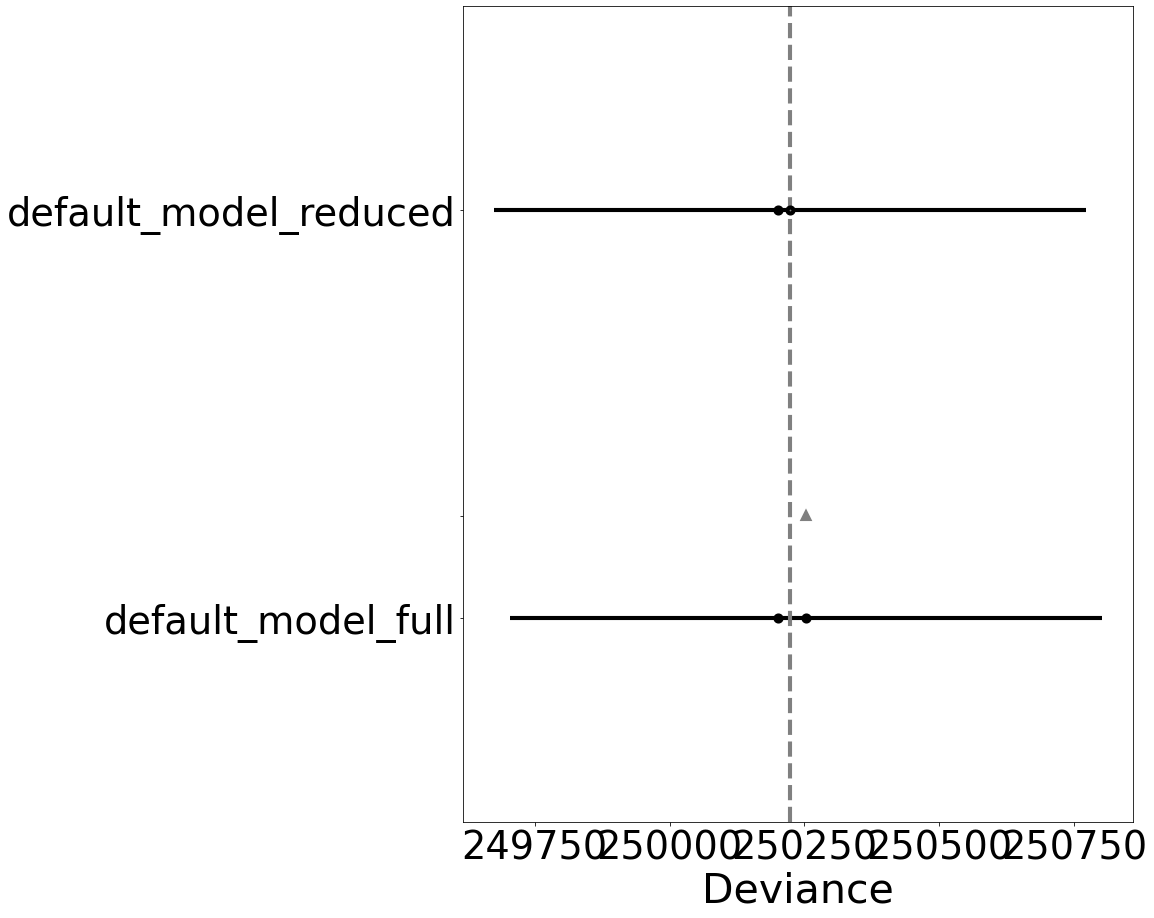

In [66]:
#WAIC comparisons
az.plot_compare(cmp_df, figsize = (12,15));

## Forest plots

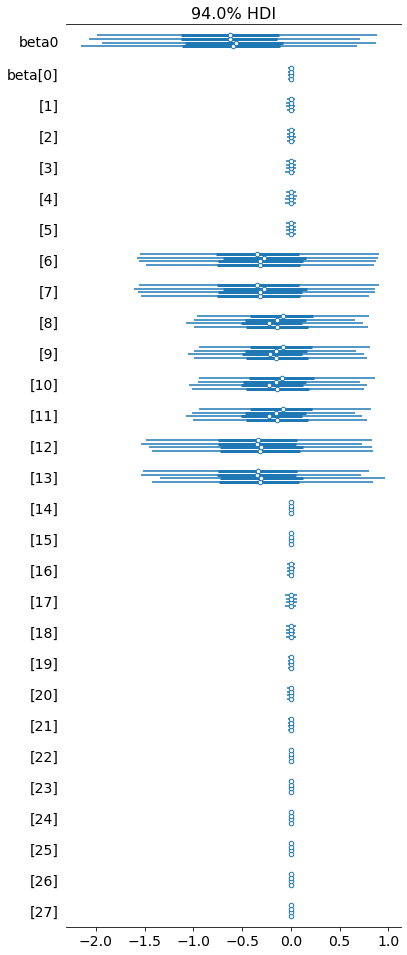

In [67]:
#full model
with pm.Model() as default_model_full:
    varnames = ['beta0', 'beta']
    az.plot_forest(trace_model_full, var_names=varnames);

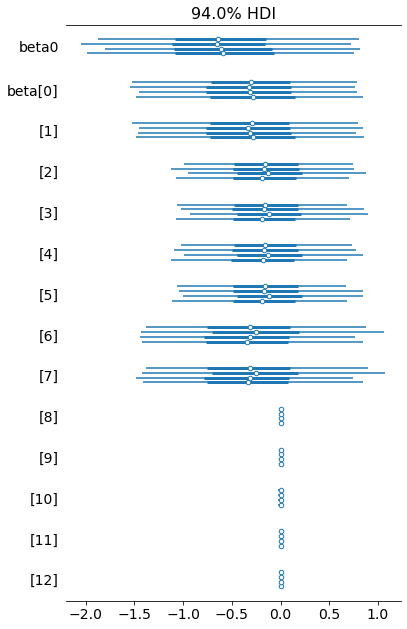

In [68]:
#reduced model
with pm.Model() as default_model_reduced:
    varnames = ['beta0', 'beta']
    az.plot_forest(trace_model_reduced, var_names=varnames);

## Variational Inference Approach 

In [69]:
#Set seed for reproducibility
SEED = 2001
np.random.seed(SEED)

In [70]:
#reduced model 
with pm.Model() as default_advi_reduced:
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    
    #mu vector of zeros length k
    beta = pm.MvNormal('beta', mu=np.zeros(k2), cov=np.eye(k2), shape=k2)
    
    mu = beta0 + pm.math.dot(reduced_sample, beta)
    theta = pm.Deterministic('theta', pm.invlogit(mu))
    
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_sample) 
    
    trace_advi_reduced = pm.sample(1000, cores=4, tune=1000)

<ipython-input-70-c57905b84008>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_advi_reduced = pm.sample(1000, cores=4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1411 seconds.


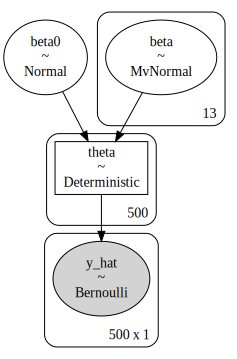

In [71]:
#graphical representation of reduced advi model
pm.model_to_graphviz(default_advi_reduced)

In [72]:
with default_advi_reduced:
    approx_full = pm.fit(50000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 1.2517e+05


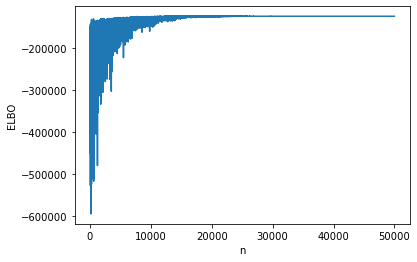

In [73]:
#generating ELBO plot 
advi_elbo = pd.DataFrame(
    {'ELBO': -approx_full.hist,
     'n': np.arange(approx_full.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo)


In [74]:
advi_trace_reduce = approx_full.sample(10000)

In [75]:
#Sample posterior predictive for ADVI reduced
y_ADVI_model_reduced = pm.sample_posterior_predictive_w(traces=[advi_trace_reduce],
                                        samples=1000,
                                        models=[default_advi_reduced])

In [76]:
#reduced model (default only)
with pm.Model() as default_advi_reduced_default_only:
    beta0 = pm.Normal('beta0', mu=0, sd=1)
    
    #mu vector of zeros length k
    beta = pm.MvNormal('beta', mu=np.zeros(k2), cov=np.eye(k2), shape=k2)
    
    mu = beta0 + pm.math.dot(reduced_total_default, beta)
    theta = pm.Deterministic('theta', pm.invlogit(mu))
    
    y_hat = pm.Bernoulli('y_hat', p=theta, observed=y_sample_total_default) 
    
    trace_advi_reduced_default_only = pm.sample(1000, cores=4, tune=1000)

<ipython-input-76-7616a5b7750a>:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_advi_reduced_default_only = pm.sample(1000, cores=4, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.


In [77]:
with default_advi_reduced_default_only:
    approx_full_default_only = pm.fit(50000, method = 'advi', random_seed = SEED)

Finished [100%]: Average Loss = 37.432


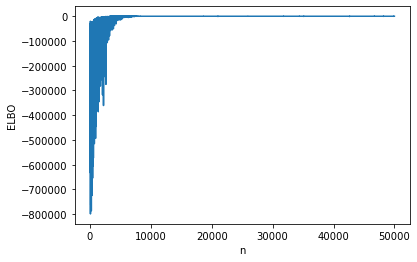

In [78]:
#generating ELBO plot 
advi_elbo_default_only = pd.DataFrame(
    {'ELBO': -approx_full_default_only.hist,
     'n': np.arange(approx_full_default_only.hist.shape[0])})

_ = sns.lineplot(y='ELBO', x='n', data=advi_elbo_default_only)


In [79]:
advi_trace_reduce_default_only = approx_full_default_only.sample(10000)

In [80]:
#Sample posterior predictive for ADVI reduced (default only)
y_ADVI_model_reduced_default_only = pm.sample_posterior_predictive_w(traces=[advi_trace_reduce_default_only],
                                        samples=1000,
                                        models=[default_advi_reduced_default_only])

## Forest plots

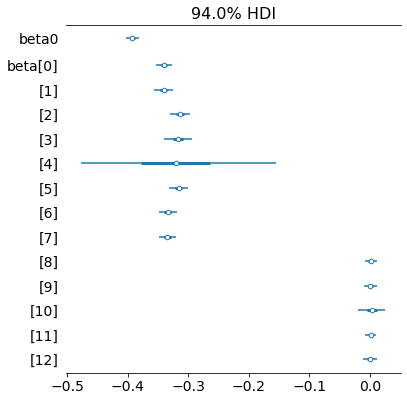

In [81]:
with pm.Model() as default_advi_reduced:
    varnames = ['beta0', 'beta']
    az.plot_forest(advi_trace_reduce, var_names=varnames);

## Posterior Predictions 

In [88]:
#Questions 
#how do we interpret some of these histogram plots
#ADVI and MCMC gave different estimates for some of the variables -> just comment on that

In [89]:
numeric_predictors = ['LIMIT_BAL', 'AGE','BILL_AMOUNT_9_2005', 'PAID_AMOUNT_9_2005']

In [90]:
categorical_predictors = ['SEX_female', 'SEX_male',  'EDUCATION_graduate.school', 
             'EDUCATION_high.school', 'EDUCATION_others', 'EDUCATION_university', 
             'MARRIAGE_married', 'MARRIAGE_single', 'PAY_DELAY_9_2005']

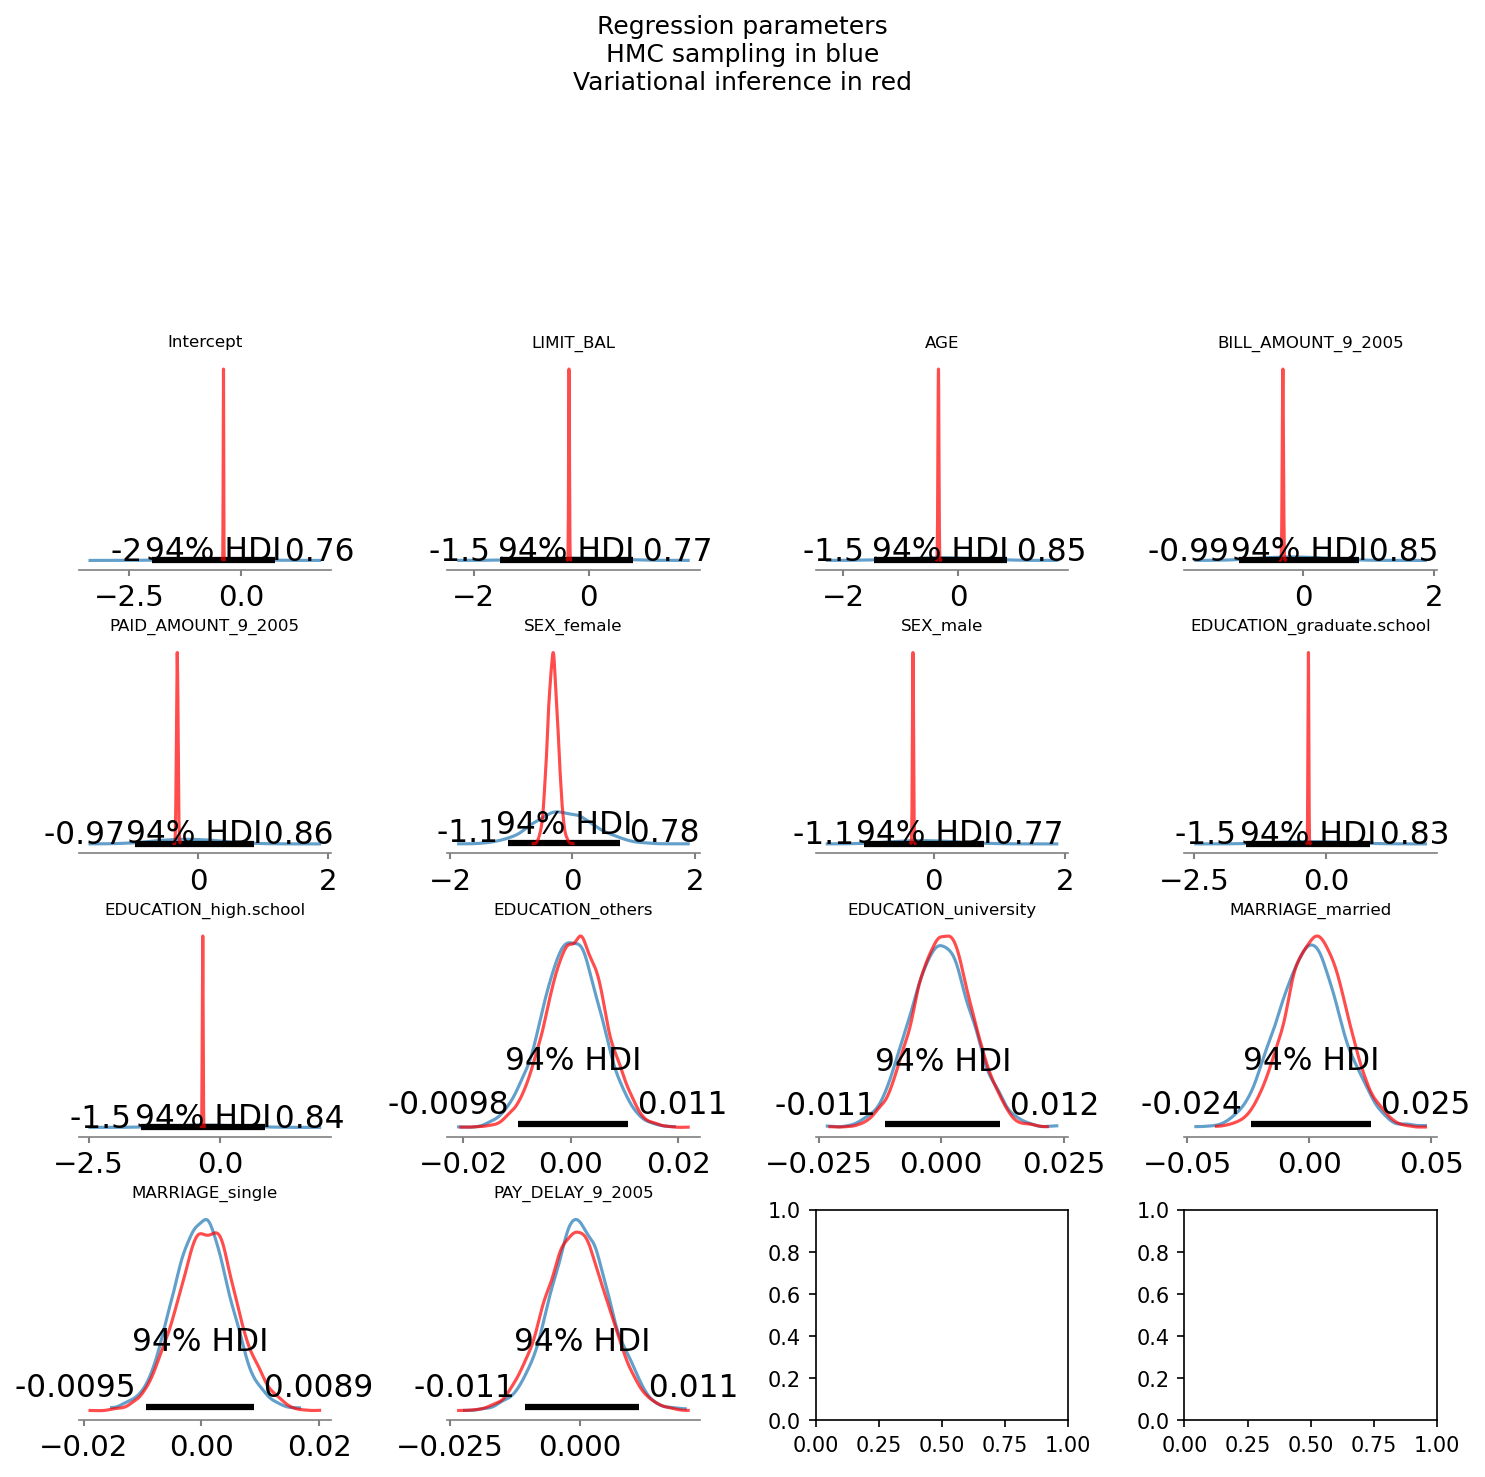

In [125]:
#Tidier visualization of posterior predictives for regression parameters 
burnin = 100
sample_intercept = trace_model_reduced['beta0'][burnin:]
#obtain sample intercept past burn in
sample_betas = trace_model_reduced['beta'][burnin:]
#obtain sample betas past burn in
advi_intercept = advi_trace_reduce['beta0']
#obtain advi intercept past burn in
advi_betas = advi_trace_reduce['beta']
#obtain advi betas past burn in

# Plot posteriors

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), dpi=150, constrained_layout=False)

for ax, estimate_sampling, estimate_advi, title, xlabel in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(13)],
                               [advi_intercept] + [advi_betas[:,i] for i in range(13)],
                               ['Intercept'] + numeric_predictors + categorical_predictors,
                                #numeric_predictors = list of numeric predictors 
                                #categorical_predictors = list of categorical
                               ['Intercept'] + numeric_predictors + categorical_predictors):
                            
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    pm.plot_posterior(estimate_advi, ax=ax, color='red', point_estimate=None, hdi_prob= 'hide', alpha=0.7)
    
    ax.set_title(title, fontsize=8)

    #ax.set_xlabel(xlabel, fontsize=10)

plt.suptitle("Regression parameters\nHMC sampling in blue\nVariational inference in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

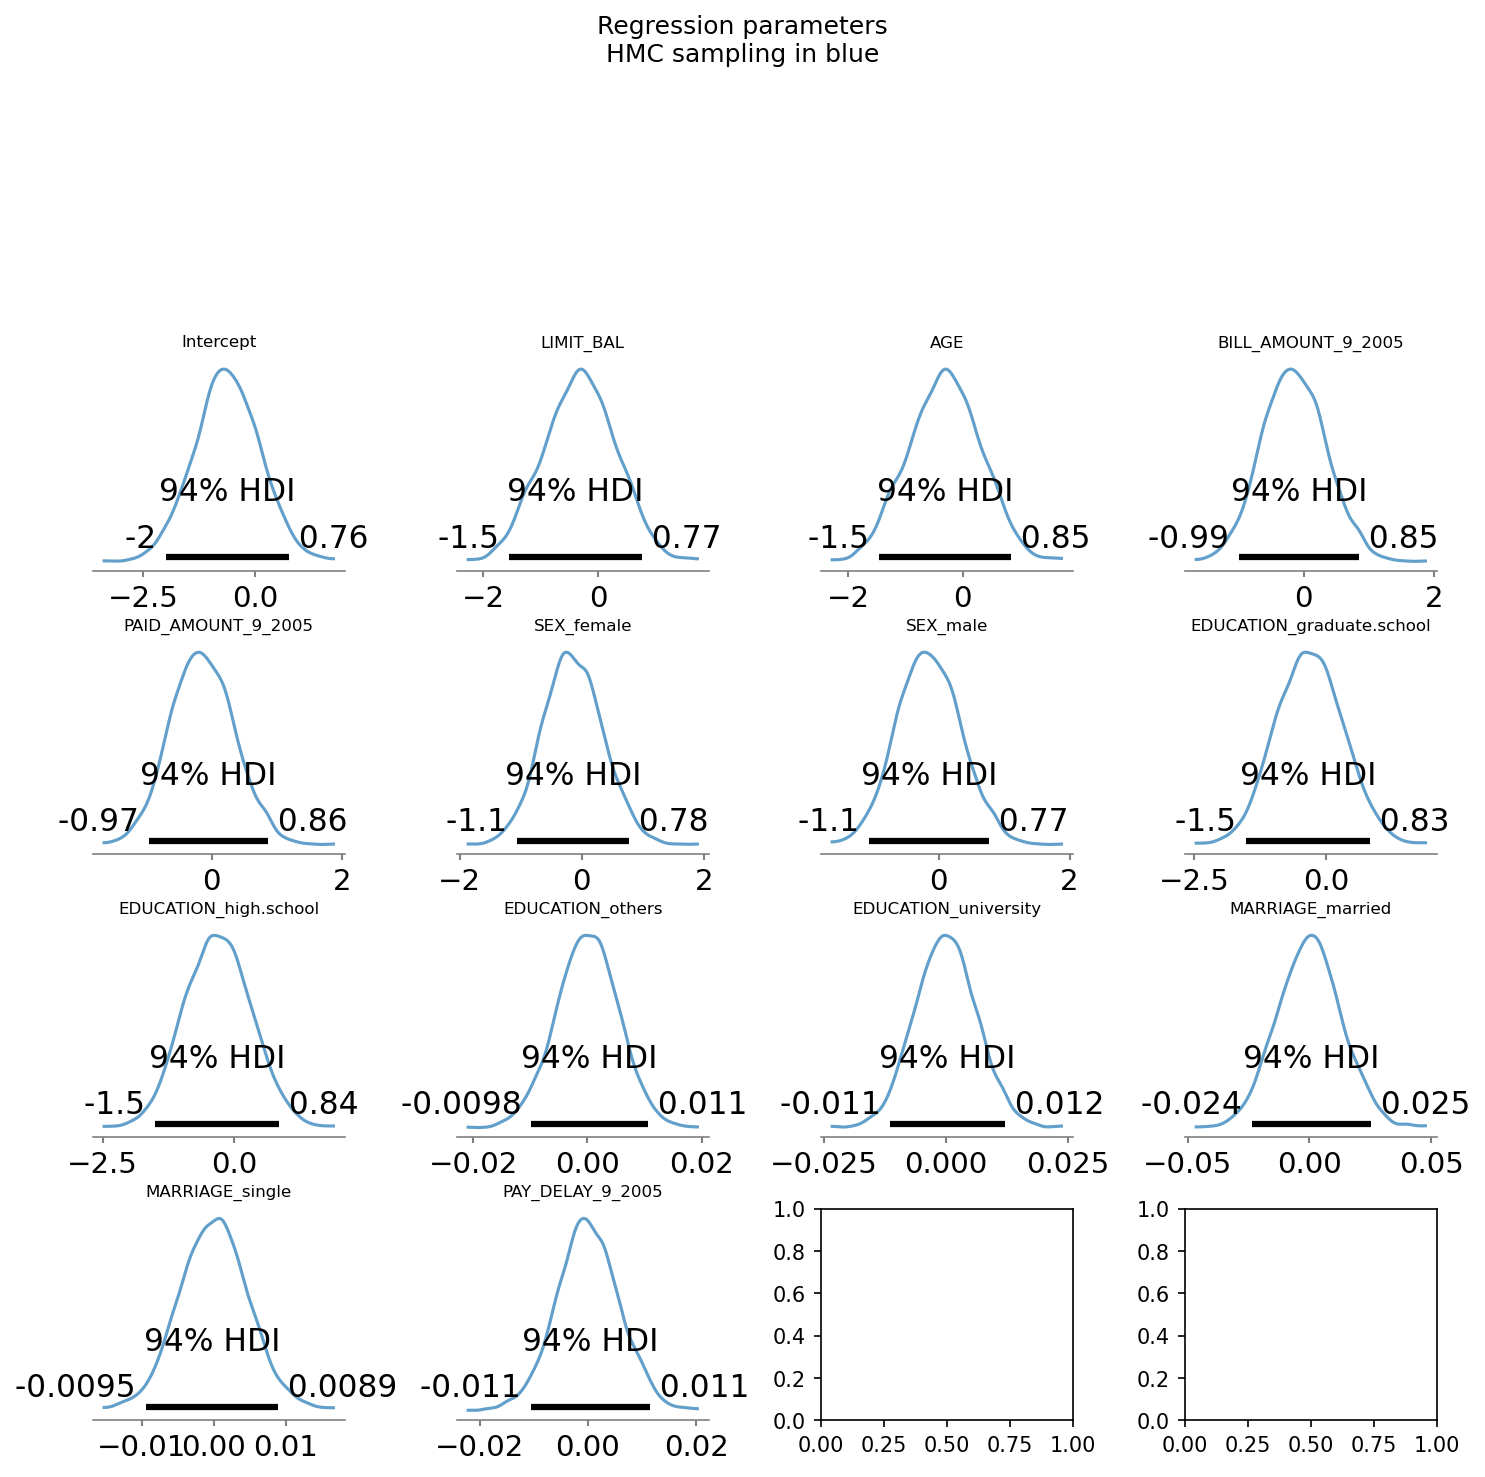

In [119]:
#Tidier visualization of posterior predictives for regression parameters (HMC only)
burnin = 100
sample_intercept = trace_model_reduced['beta0'][burnin:]
sample_betas = trace_model_reduced['beta'][burnin:]

# Plot posteriors

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), dpi=150, constrained_layout=False)

for ax, estimate_sampling, title in zip(axes.ravel(),
                               [sample_intercept] + [sample_betas[:,i] for i in range(13)],
                               ['Intercept'] + numeric_predictors + categorical_predictors):
                                #numeric_predictors = list of numeric predictors 
                                #categorical_predictors = list of categorical
                            
    pm.plot_posterior(estimate_sampling, ax=ax,point_estimate=None,  alpha=0.7)
    
    ax.set_title(title, fontsize=8)

plt.suptitle("Regression parameters\nHMC sampling in blue")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

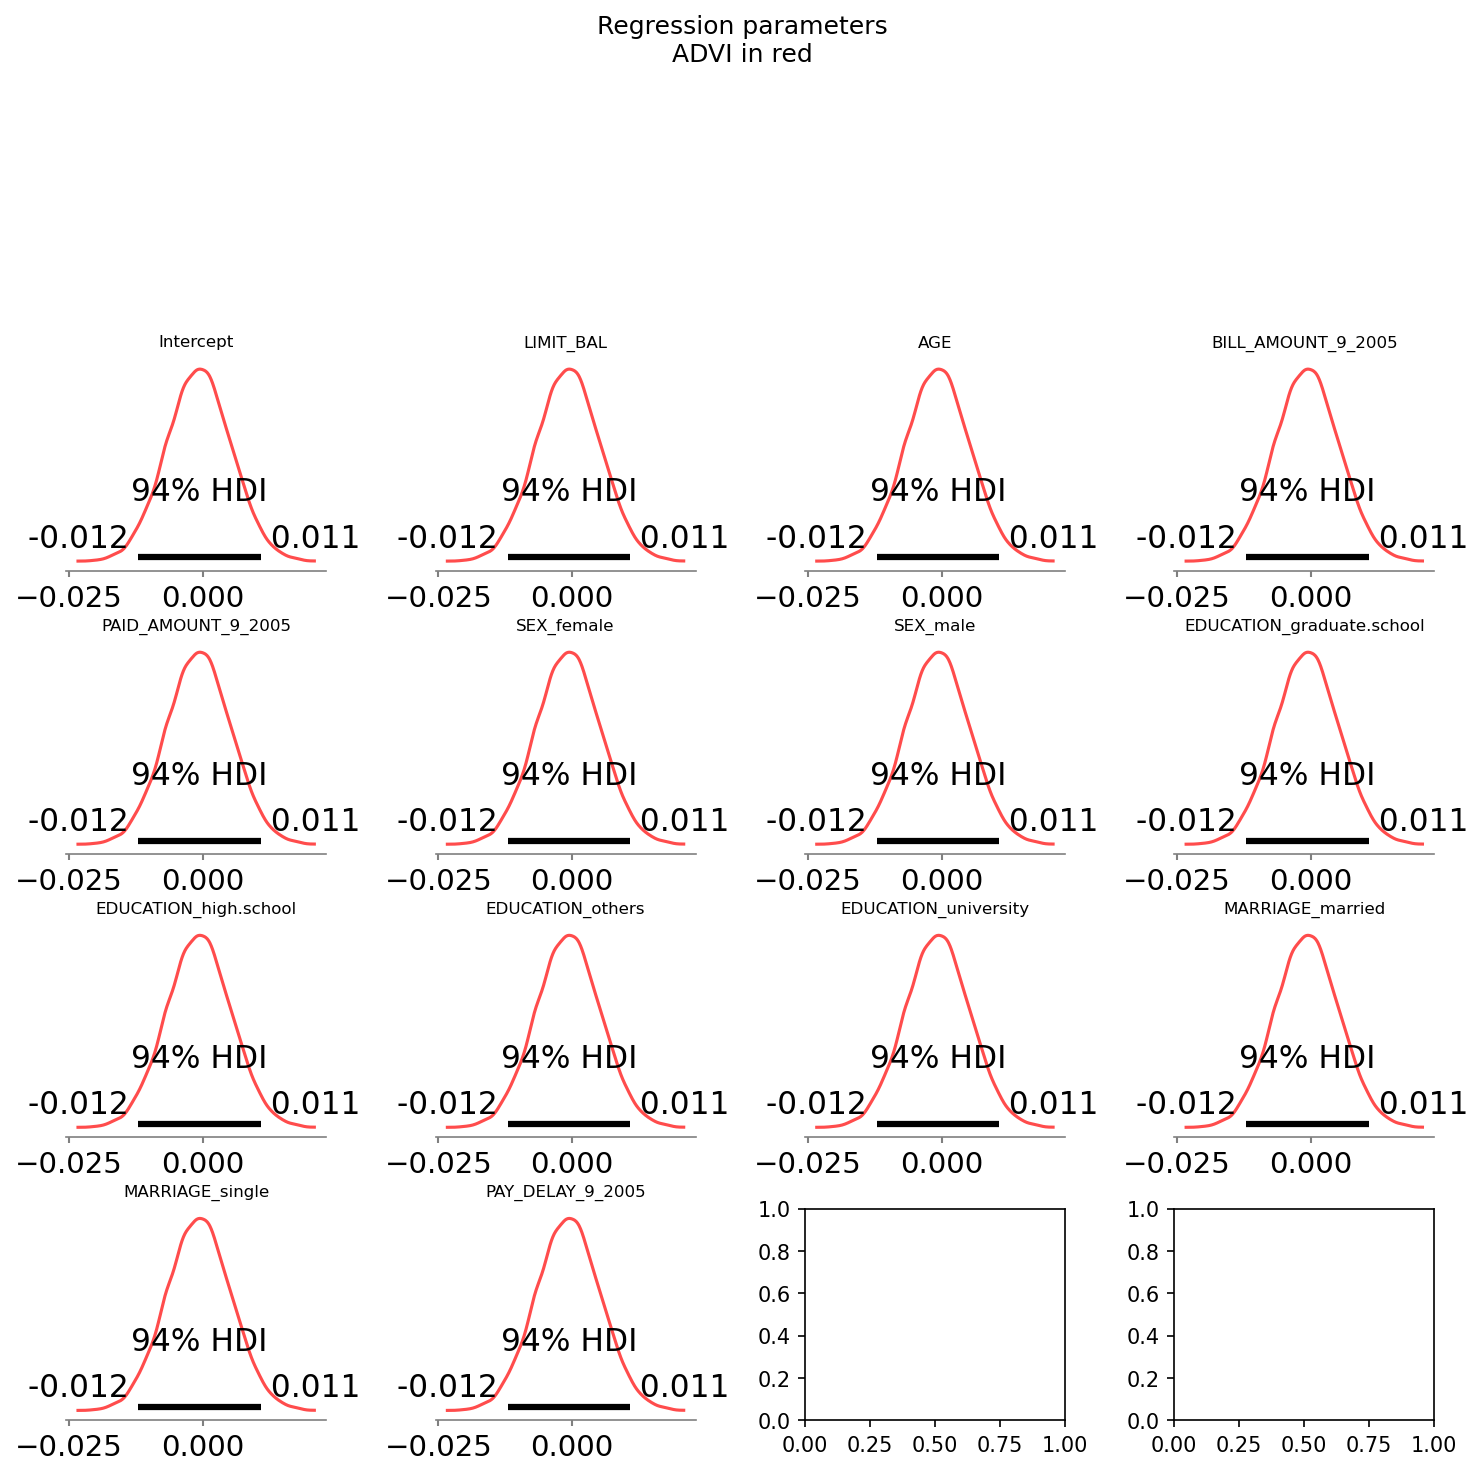

In [126]:
#Tidier visualization of posterior predictives for regression parameters (ADVI only)
burnin = 100
advi_intercept = advi_trace_reduce['beta0']
advi_betas = advi_trace_reduce['beta']

# Plot posteriors
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10), dpi=150, constrained_layout=False)

for ax, estimate_sampling, title in zip(axes.ravel(),
                               [advi_intercept] + [advi_betas[:,i] for i in range(13)],
                               ['Intercept'] + numeric_predictors + categorical_predictors):
                                #numeric_predictors = list of numeric predictors 
                                #categorical_predictors = list of categorical
                            
    pm.plot_posterior(estimate_advi, ax=ax,point_estimate=None, color='red', alpha=0.7)

    ax.set_title(title, fontsize=8)

plt.suptitle("Regression parameters\nADVI in red")
plt.tight_layout()
plt.subplots_adjust(top=0.75)
plt.show()

In [92]:
#Ask how to plot posterior of prediction for HMC and ADVI (ie is it the same as the last plot in Homework 4 Question 3)

In [93]:
#Posterior prediction of response (default)

In [94]:
cmp_df

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
default_model_reduced,0,250223.175601,10.980964,0.000000,9.999997e-01,549.580874,0.000000,False,deviance
default_model_full,1,250253.017471,25.899188,29.841871,3.365508e-07,549.488772,0.332328,False,deviance


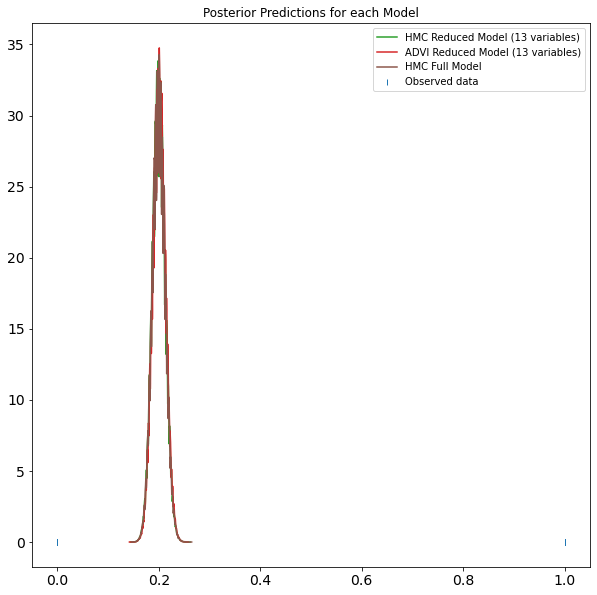

In [98]:
#Bayesian model average result (kde plots)
_, ax = plt.subplots(figsize=(10, 10))
az.plot_kde(y_HMC_model_pred['y_hat'].mean(0), plot_kwargs={'color': 'C2'}, label='HMC Reduced Model (13 variables)', ax=ax)
az.plot_kde(y_ADVI_model_reduced['y_hat'].mean(0), plot_kwargs={'color': 'C3'}, label='ADVI Reduced Model (13 variables)', ax=ax)
az.plot_kde(y_HMC_model_pred_full['y_hat'].mean(0), plot_kwargs={'color': 'C5'}, label='HMC Full Model', ax=ax)

plt.plot(y_sample, np.zeros_like(y_sample), '|', label='Observed data')
plt.title('Posterior Predictions for each Model')
plt.legend()

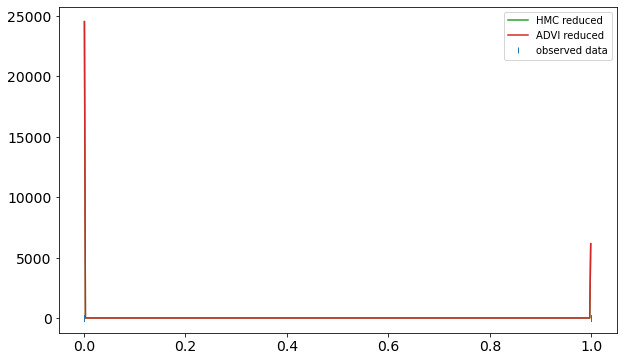

In [106]:
# KDE plots
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_HMC_model_pred['y_hat'], plot_kwargs={'color': 'C2'}, label='HMC reduced', ax=ax)
az.plot_kde(y_ADVI_model_reduced['y_hat'], plot_kwargs={'color': 'C3'}, label='ADVI reduced', ax=ax)

plt.plot(y_sample, np.zeros_like(y_sample), '|', label='observed data')
#plt.yticks([])
plt.legend()


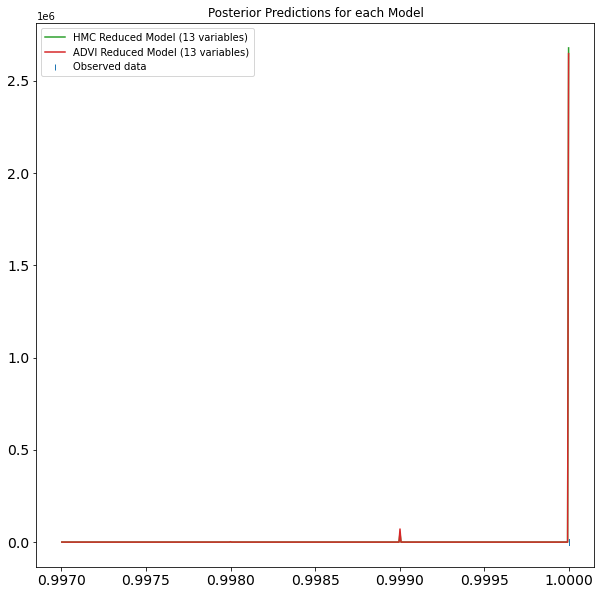

In [107]:
#Bayesian model average result (kde plots) for default only data
_, ax = plt.subplots(figsize=(10, 10))
az.plot_kde(y_HMC_model_reduced_default_only['y_hat'].mean(0), plot_kwargs={'color': 'C2'}, label='HMC Reduced Model (13 variables)', ax=ax)
az.plot_kde(y_ADVI_model_reduced_default_only['y_hat'].mean(0), plot_kwargs={'color': 'C3'}, label='ADVI Reduced Model (13 variables)', ax=ax)
#az.plot_kde(y_HMC_model_pred_full['y_hat'].mean(0), plot_kwargs={'color': 'C5'}, label='HMC Full Model', ax=ax)

plt.plot(y_sample_total_default, np.zeros_like(y_sample_total_default), '|', label='Observed data')
plt.title('Posterior Predictions for each Model')
plt.legend()

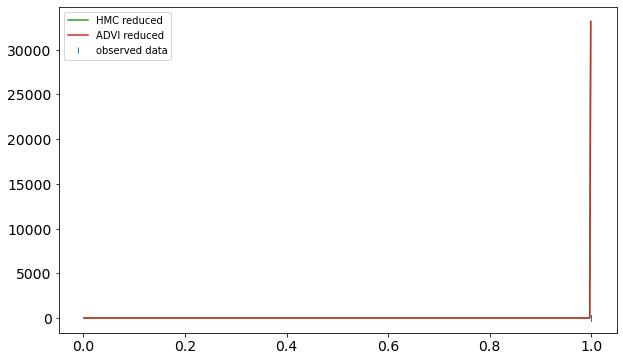

In [108]:
# KDE plots for default only data
_, ax = plt.subplots(figsize=(10, 6))
az.plot_kde(y_HMC_model_reduced_default_only['y_hat'], plot_kwargs={'color': 'C2'}, label='HMC reduced', ax=ax)
az.plot_kde(y_ADVI_model_reduced_default_only['y_hat'], plot_kwargs={'color': 'C3'}, label='ADVI reduced', ax=ax)

plt.plot(y_sample_total_default, np.zeros_like(y_sample_total_default), '|', label='observed data')
#plt.yticks([])
plt.legend()
